In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from rasterio.warp import transform
from pyproj import Transformer
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Load shapefiles
wg = gpd.read_file("/Users/subin/Downloads/Shape_files/wg_bnd/wg_bnd.shp")
world = gpd.read_file("/Users/subin/Downloads/Shape_files/world_boundaries/World_Countries_shp.shp")

# Ensure CRS is WGS84
wg = wg.to_crs("EPSG:4326")
world = world.to_crs("EPSG:4326")

# Clip world shapefile to region of interest
bbox = (65, 0, 85, 20)
world_clipped = world.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]

In [3]:
# -------- CONFIGURATION --------
##############Time 00:30 UTC#####################################
#bt_file = "3SIMG_29JUL2024_0030_L1C_ASIA_MER_V01R00_IMG_TIR1.tif"
#core_lat = 10.01
#core_lon = 75.67
#figname = "29 July 2024 06:00 IST"
##############Time 03:30 UTC#####################################
#bt_file = "3SIMG_29JUL2024_0330_L1C_ASIA_MER_V01R00_IMG_TIR1.tif"
#core_lat = 11.46
#core_lon = 75.97
#figname = "29 July 2024 09:00 IST"
##############Time 06:30 UTC#####################################
#bt_file = "3SIMG_29JUL2024_0630_L1C_ASIA_MER_V01R00_IMG_TIR1.tif"
#core_lat = 11.90
#core_lon = 75.44
#figname = "29 July 2024 12:00 IST"
##############Time 09:30 UTC#####################################
#bt_file = "3SIMG_29JUL2024_0930_L1C_ASIA_MER_V01R00_IMG_TIR1.tif"
#core_lat = 11.09
#core_lon = 75.06
#figname = "29 July 2024 15:00 IST"
##############Time 12:30 UTC#####################################
#bt_file = "3SIMG_29JUL2024_1230_L1C_ASIA_MER_V01R00_IMG_TIR1.tif"
#core_lat = 10.42
#core_lon = 76.20
#figname = "29 July 2024 18:00 IST"
##############Time 15:30 UTC#####################################
#bt_file = "3SIMG_29JUL2024_1530_L1C_ASIA_MER_V01R00_IMG_TIR1.tif"
#core_lat = 11.35
#core_lon = 75.18
#figname = "29 July 2024 21:00 IST"
##############Time 18:30 UTC#####################################
#bt_file = "3SIMG_29JUL2024_1830_L1C_ASIA_MER_V01R00_IMG_TIR1.tif"
#core_lat = 11.16
#core_lon = 75.67
#figname = "30 July 2024 00:00 IST"
##############Time 21:30 UTC#####################################
bt_file = "3SIMG_29JUL2024_2130_L1C_ASIA_MER_V01R00_IMG_TIR1.tif"
core_lat = 12.16
core_lon = 74.68
figname = "30 July 2024 03:00 IST"
##############Time 22:30 UTC#####################################
#bt_file = "3SIMG_29JUL2024_2230_L1C_ASIA_MER_V01R00_IMG_TIR1.tif"
#core_lat = 12.12
#core_lon = 73.70
#figname = "30 July 2024 04:00 IST"

In [4]:
# MCC criteria thresholds
shield_thresh = 241.15  # -32°C
core_thresh = 221.15    # -52°C

# Discrete color scale
bounds = [190, 220, 230, 240, 250, 260, 310]
colors = ['darkred', 'red', 'orangered', 'orange', 'gold', 'skyblue']
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

In [5]:
# -------- LOAD & PROCESS DATA --------
with rasterio.open(bt_file) as src:
    bt_data = src.read(1)
    transform_affine = src.transform
    crs = src.crs
    height, width = bt_data.shape

# Create BT threshold masks
shield_mask = bt_data <= shield_thresh
core_mask = bt_data <= core_thresh

# Calculate approximate area (in km²)
pixel_size_m = abs(transform_affine.a)
pixel_area_km2 = (pixel_size_m ** 2) / 1e6
shield_area = np.sum(shield_mask) * pixel_area_km2
core_area = np.sum(core_mask) * pixel_area_km2

# Create lat/lon grid
rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
xs, ys = rasterio.transform.xy(transform_affine, rows, cols, offset='center')
xs = np.array(xs)
ys = np.array(ys)

transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
lon_grid, lat_grid = transformer.transform(xs, ys)


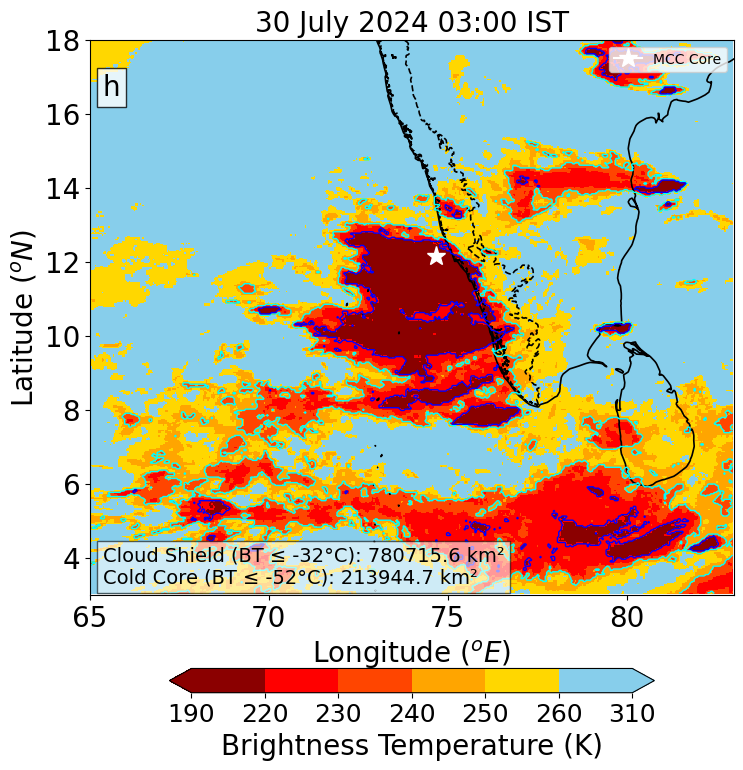

In [6]:
# --- Plotting ---
fig, ax = plt.subplots(figsize=(10, 8))

# Plot BT with discrete colormap
im = ax.pcolormesh(lon_grid, lat_grid, bt_data, cmap=cmap, norm=norm, shading='auto')
#cbar = plt.colorbar(im, ax=ax, boundaries=bounds, ticks=bounds)
cbar = fig.colorbar(im, ax=ax, orientation="horizontal", shrink=0.5, pad=0.1, extend='both')
cbar.set_label("Brightness Temperature (K)",fontsize=20)
cbar.ax.tick_params(labelsize=18)
# Add shapefile overlays
world_clipped.boundary.plot(ax=ax, edgecolor='black', linewidth=1.2)
wg.boundary.plot(ax=ax, edgecolor='black', linewidth=1.2, linestyle='--')

# MCC contours
ax.contour(lon_grid, lat_grid, shield_mask, levels=[0.5], colors='cyan', linewidths=1)
ax.contour(lon_grid, lat_grid, core_mask, levels=[0.5], colors='blue', linewidths=1)

# Star mark for MCC core
ax.plot(core_lon, core_lat, marker='*', color='white', markersize=14, label='MCC Core')

# Info box
info_text = (
    f"Cloud Shield (BT ≤ -32°C): {shield_area:.1f} km²\n"
    f"Cold Core (BT ≤ -52°C): {core_area:.1f} km²"
)
ax.text(0.02, 0.02, info_text, transform=ax.transAxes, fontsize=14,
        bbox=dict(facecolor='white', alpha=0.6))
ax.text(0.02, 0.9, 'h', transform=ax.transAxes, fontsize=20,bbox=dict(facecolor='white', alpha=0.8))
ax.set_xlim(65, 83)
ax.set_ylim(3, 18)
ax.tick_params(axis='both', which='major', labelsize=20)
# Final formatting
ax.set_xlabel("Longitude ($^oE$)",fontsize=20)
ax.set_ylabel("Latitude ($^oN$)",fontsize=20)
ax.set_title(figname,fontsize=20)
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig(figname + ".png", dpi=300, bbox_inches='tight')
plt.show()